In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project 4 - Motion Planning

### Introduction to Trajectory Optimization
- Introduce dynamics equations As + Bu = z
- Single obstacle encoding as constraints
    - Demonstrate creating a convex polygon bound
    - Show constraint formulation for OR constraints using big M notation
- Speed limit
    - Quadratic constraint on s'

## Simple Robot Path Planning - Single Obstacle

We'll start by considering a simplified version of our ultimate problem, and examine constraint-based path planning throgh a single-obstacle environment to reach a single goal. In an 8x8 unit environment, we define our problem conditions as follows:

- Robot Start Point: `(1,1)`
- Goal Region: Rectangle region bounded by `[(6,6), (6,7), (7,7), (7, 6)]`
- Obstacles: Single obstacle bounded by `[(3,2), (2,5), (6,3)]`

Our goal will be to minimize distance traveled.

Run the code in the next cell to preview the starting environment.



(5.5, 5.5)


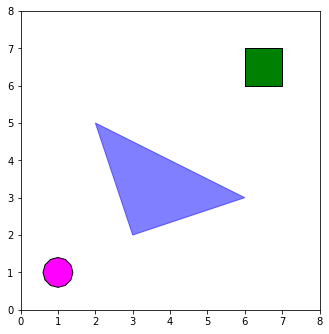

In [5]:
# Sample Problem
obstacles = [(3,2), (2,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In order to simplify the problem, we would like to treat our robot as a point object. To do this, we add a buffer, equal to the robot's radius, to every obstacle in the environment. This allows us to consider the robot as a point, rather than a moving area, and still take into account the robot's size to avoid collision with obstacles. 

To make this easy, we'll use the `pyclipper` package to create the buffer. The example code below performs this task for our example environment and obstacle:

(5.5, 5.5)
Buffered Obstacles: 
 [[[6.521310369484127, 2.9629516126587987], [1.6575750685296953, 5.394819263368845], [2.8735088938847184, 1.7470177877694368]]]


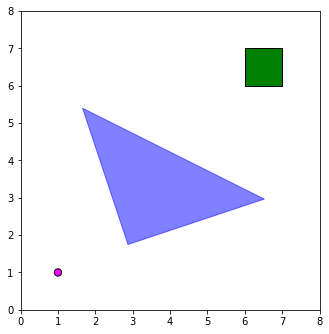

In [6]:
# Redefine obstacles with radius of droid; treat droid as a point robot
obs = (obstacles)
pco = pyclipper.PyclipperOffset()
pco.MiterLimit = 10
pco.AddPath(pyclipper.scale_to_clipper(obs), pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
buff_obs = pyclipper.scale_from_clipper(pco.Execute(pyclipper.scale_to_clipper(.2)))

env = Environment(None)
env.add_obstacles([Polygon(buff_obs[0])])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.1, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

print('Buffered Obstacles: \n', buff_obs)

**Dynamics equations:** 

In this part, we will incorporate robot dynamics, time (arrival) constraints. The initial location, goal locations, the geometry of factory and obstacles, and vehicle speed limits are the inputs. In this case, we assume that the robots always move at the top speed to meet the time constraints. And the effect of acceleration is ignored, which means that the robot can always move at the desired velocity at a given time. And all the physical parameters of the robots are the same. 

Under these assumptions, the only dynamic equation can be written as:

$$ s = u*t $$

where s is the distance the robot can travel; u is the max velocity; and t is the time duration. And it can be translated into the matrix form:

$$  \begin{pmatrix}x_{i+1}\\y_{i+1}\\\dot{x}_{i+1}\\\dot{y}_{i+1}\end{pmatrix} = \begin{pmatrix}1&0& \bigtriangleup t &0\\0&1&0&\bigtriangleup t\\0&0&1&0\\0&0&0&1\end{pmatrix}  \begin{pmatrix}x_{i}\\y_{i}\\\dot{x}_{i}\\\dot{y}_{i}\end{pmatrix}$$


**Obstacle encoding as constraints**

Since all the obstacles in this problem are stationary, we can easily encode arbitrarily shaped obstacles using constraints. And exactly 1 of them must be applied. And the concave shape can be dealt with by chopping them into multiple convex objects, or by setting a convex boundary that encompasses the entire shape.

For example, if the obstacle is a square shaped by [X_min, X_max] and [Y_min, Y_max]. The obstacle can be expressed by: 

$$  \forall i  \in [1,2,3,...,]:$$
$$ x_i <=x_{min}$$
or $$ x_i >=x_{max}$$
or $$ y_i <=y_{min}$$
or $$  y_i >=y_{max}$$

And for the workstations in this task formed by straight lines, the constraints can be expressed with the line function for each edge.

### Next we must reformulate these constraints to get rid of the "OR" statements, as this would make the program non-linear

- Do this here, using big M notation as shown in lecture slides

**The speed limit**

The speed limit in this case is provided by the problem for each robot. And we assume that the robots move at the max allowed speed provided. 

### Space Station Problem Introduction
- Go through same steps as above
- Introduce multi-vehicle problem
    - Collision avoidance
    - Each waypoint visited by only one vehicle

In the real space station problem, it is a little different from the simplified problem above. The number of robots is bigger than 1, which means that we need to add dynamic equations and constrait equations for each robot. One of the big change here is the non-collision constraint, which can be formalized by that all the robot pairs keep a minimum distance accoding their own coordination. But the process to solve the problem is relatively similar as the one we use in the simplified problem.

### Encoding of Problem - MIQCP

Since the speed limit is given, the distance traveled in a given time step is a quadratic constraint. 

Thus the whole problem can be encoded as a motion planning problem based on MIQCP with the constriant of speed limitation, time limitation (termination constraint), non-collision constraint, obstacle constraint with the objective function of time to finish the whole task. 

## Outstanding Questions
- What is the data structure we will be using for obstacles, paths, etc? Similar to HW6?
- Are workstations that are not the current goal to be treated as obstacles?
- Objective function = minimize time?
- Multiple droids? These must avoid eachother while moving, right? How many?
- Are we ignoring acceleration, and only considering velocity? So robots are stopped or traveling at max speed at all times?
- Which solver are we using?
